![sf-weather](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/sf-weather.jpg)

# Weather prediction using Recurrent Neural Network
### Dr. Tirthajyoti Sarkar, Fremont, CA ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

In this Notebook, we show how the long-term trend of key weather parameters (humidity, temperature, atmospheric pressure, etc.) can be predicted with decent accuracy using simple recurrent neural network (RNN). We don't even need to use any sophisticated memory module like GRU or LSTM for this. A simple one-layer RNN based model seems sufficient to be able to predict long-term trends from limited training data surprisingly well.

This is almost a proof of what Andrej Karpathy famously called **["The unusual effectiveness of recurrent neural networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)**

### The dataset
The dataset consists of historical weather parameters (temperature, pressure, relative humidity) for major North American and other cities around the world over an extended time period of 2012 to 2017. Hourly data points are recorded, giving, over 45000 data points, in total.

By attepmpting to do a time-series prediction, we are implicitly assuming that the past weather pattern is a good indicator of the future.

For this analysis, we focus only on the data for the city of San Francisco.

The full dataset can be found here: https://www.kaggle.com/selfishgene/historical-hourly-weather-data

## Data loading and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
humidity = pd.read_csv("data_exercise/humidity.csv")
temp = pd.read_csv("data_exercise/temperature.csv")
pressure = pd.read_csv("data_exercise/pressure.csv")

In [3]:
humidity_SF = humidity[['datetime','San Francisco']]
temp_SF = temp[['datetime','San Francisco']]
pressure_SF = pressure[['datetime','San Francisco']]

In [4]:
humidity_SF.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [10]:
humidity_SF.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [11]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45253, 2)
(45253, 2)
(45253, 2)


### There are many `NaN` values (blanck) in the dataset

In [12]:
# Count them

How many NaN are there in the humidity dataset? 942
How many NaN are there in the temperature dataset? 793
How many NaN are there in the pressure dataset? 815


### Choosing a point in the time-series for training data

We choose Tp=7000 (7000 training points) here which means we will train the RNN with only first 7000 data points and then let it predict the long-term trend (for the next > 35000 data points or so). That is not a lot of training data compared to the number of test points, is it? 

Plot the training points of the features.

### Interpolate data points to fill up `NaN` values
We observed some `NaN` values in the dataset. We could just eliminate these points. But assuming that the changes in the parameters are not extremely abrupt, we could try to fill them using simple linear interpolation.

In [70]:
# Use interpolation to fill the NaN values.

In [13]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45252, 2)
(45252, 2)
(45252, 2)


### Train and test splits on the `Tp=7000`

In [50]:
# split just on train and test
# can you plot the train vs test points?

In [16]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000,)
Test data length: (38252,)


### Choose the embedding or step size
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=8`. In more complex RNN and in particular for text processing, this is also called _embedding size_. The idea here is that **we are assuming that 8 hours of weather data can effectively predict the 9th hour data, and so on.**

In [19]:
step = 8

In [52]:
# add step elements into train and test
#train:
train = np.append(train,np.repeat(train[-1,],step))

#do the same for test. Make sure you understand what we are doing!

In [53]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7008,)
Test data length: (38260,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [22]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [1]:
# use the above function to create trainX, trainY and testX, testY


# watch out for the reshape

In [56]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (38252, 1, 8) ,  (38252,)


## Modeling

### Keras model with `SimpleRNN` layer

We build a simple function to define the RNN model. It uses a single neuron for the output layer because we are predicting a real-valued number here. As activation, it uses the ReLU function. Following arguments are supported.

- neurons in the RNN layer
- embedding length (i.e. the step length we chose)
- nenurons in the densely connected layer
- learning rate

In [26]:
# Define and train your model.



### Plot RMSE loss over epochs
Note that the `loss` metric available in the `history` attribute of the model is the MSE loss and you have to take a square-root to compute the RMSE loss.

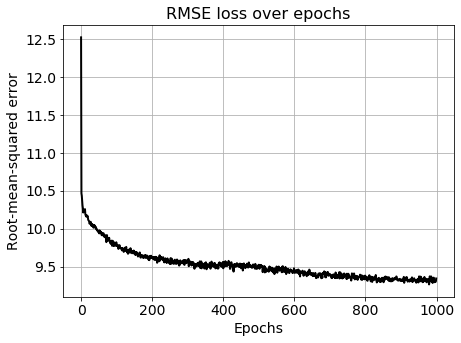

In [32]:
# Your code here


## Result and analysis

### What did the model see while training?
We are emphasizing and showing again what exactly the model see during training. If you look above, the model fitting code is,

```
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)
```

So, the model was fitted with `trainX` which is plotted below, and `trainY` which is just the 8 step shifted and shaped vector.

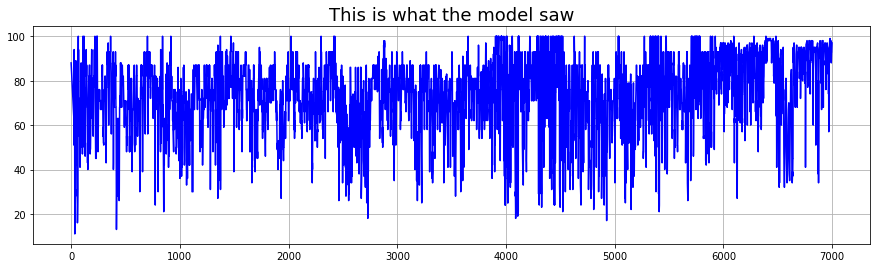

In [33]:
# Plot your train data (trainX)

### Now predict the future points
Now, we can generate predictions for the future by passing `testX` to the trained model.

In [57]:
# Generate your predictions

### See the magic!

When we plot the predicted vector, we see it matches closely the true values and that is amazing given how little training data was used and how far in the _future_ it had to predict. Time-series techniques like ARIMA, Exponential smoothing, cannot predict very far into the future and their confidence interval quickly grows beyond being useful.

**Note carefully how the model is able to predict sudden increase in humidity around time-points 12000. There was no indication of such shape or pattern of the data in the training set, yet, it is able to predict the general shape pretty well from the first 7000 data points!**

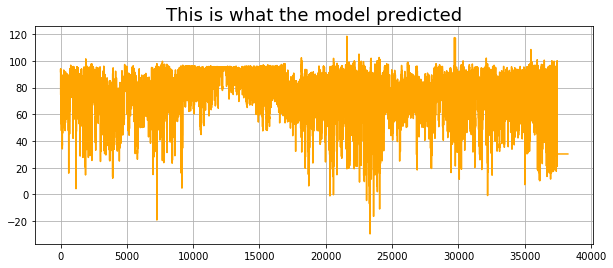

In [58]:
# Plot your predictions.

### Plotting the ground truth and model predictions together
We plot the ground truth and the model predictions together to show that it follows the general trends in the ground truth data pretty well. Considering less than 25% data was used for training, this is sort of amazing. The boundary between train and test splits is denoted by the vertical red line.

There are, of course, some obvious mistakes in the model predictions, such as humidity values going above 100 and some very low values. These can be pruned with post-processing or a better model can be built with propoer hyperparameter tuning.

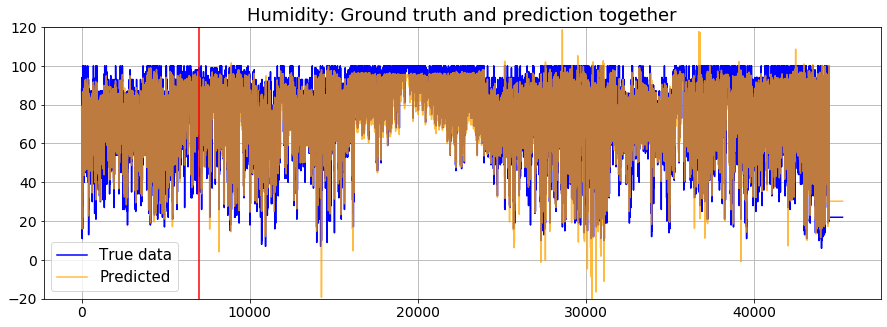

In [59]:
# Plot your predictions compared with the true data

### Once the humidity data has been analyzed, we invite you to do the same with the temperature and atmospheric pressure data. State the conclusions that you think are appropriate. The code should be very similar.